In [1]:
import torch
import numpy as np

\begin{align}
y_1 = 2x_1^2 + 3x_2^2 -7x_3^2 -5x_1 + 11x_2 + 2x_3 + 3
\end{align}


\begin{align}
y_2 = 13x_1^2 - 11x_2^2 +7x_3^2 +2x_1 + 19x_2 - 13x_3 + 5
\end{align}

In [2]:
def generate_data(low = 0.0, high = 1.0, n=100, d=3):
    np.random.seed(73)
    return np.random.uniform(low, high, (n,d))

def quadratic_func(x, sq_coef, li_coef, bias):
    """Outputs a quadratic function with n variables  
    (based on dimension of ndarray and value of coefficients passed). 
    The number of dimensions and the number of coefficients should match"""
    sq_x = np.square(x)
    return sq_x @ sq_coef.T + x @ li_coef.T + bias
    
x = generate_data(-1.0,1.0,300, 3)

y1 = quadratic_func(x, np.array([[2,3,-7]]), np.array([[-5,11,2]]), 3)
y2 = quadratic_func(x, np.array([[13,-11,7]]), np.array([[2,19,-13]]), 5)

In [3]:
def plot_4d(x1,x2,x3,y_true,y_pred=None):
    %matplotlib inline
    %matplotlib notebook

    from matplotlib import cm
    from matplotlib import colors
    from mpl_toolkits import mplot3d
    import matplotlib.pyplot as plt

    plt.rcParams["figure.figsize"] = 17, 10
    ax = plt.axes(projection='3d')
    
    max_y = np.max(y_true)
    min_y = np.min(y_true)
    
    if y_pred is not None:
        mx_pred = np.max(y_pred)
        mn_pred = np.min(y_pred)
        if mx_pred > max_y:
            max_y = mx_pred
        if mn_pred < min_y:
            min_y = mn_pred
    
    cmap = cm.get_cmap('seismic')
    norm = colors.Normalize(vmin=min_y,vmax=max_y)
    print(f'max : {max_y}  min : {min_y}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    sc1 = ax.scatter(x1, x2, x3,s=np.square(y_true[:,0] + 2),c=y_true[:,0] ,norm=norm, cmap=cmap)
    cb1 = plt.colorbar(sc1)
    cb1.set_label('y_true')
    if y_pred is not None:
        cmap2 = cm.get_cmap('PRGn')
        sc2 = ax.scatter(x1, x2, x3,s=np.square(y_pred[:,0] + 2),c=y_pred[:,0] ,norm=norm, cmap=cmap2)
        cb2 = plt.colorbar(sc2)
        cb2.set_label('y_pred')
#     sc = ax.scatter(x[:,0], x[:,1], x[:,2],s=np.square(y1[:,0] + 2),c=y1[:,0] ,norm=norm, cmap=cmap)
    plt.xlabel='x1'
    plt.ylabel='x2'
    plt.zlabel='x3'

<IPython.core.display.Javascript object>


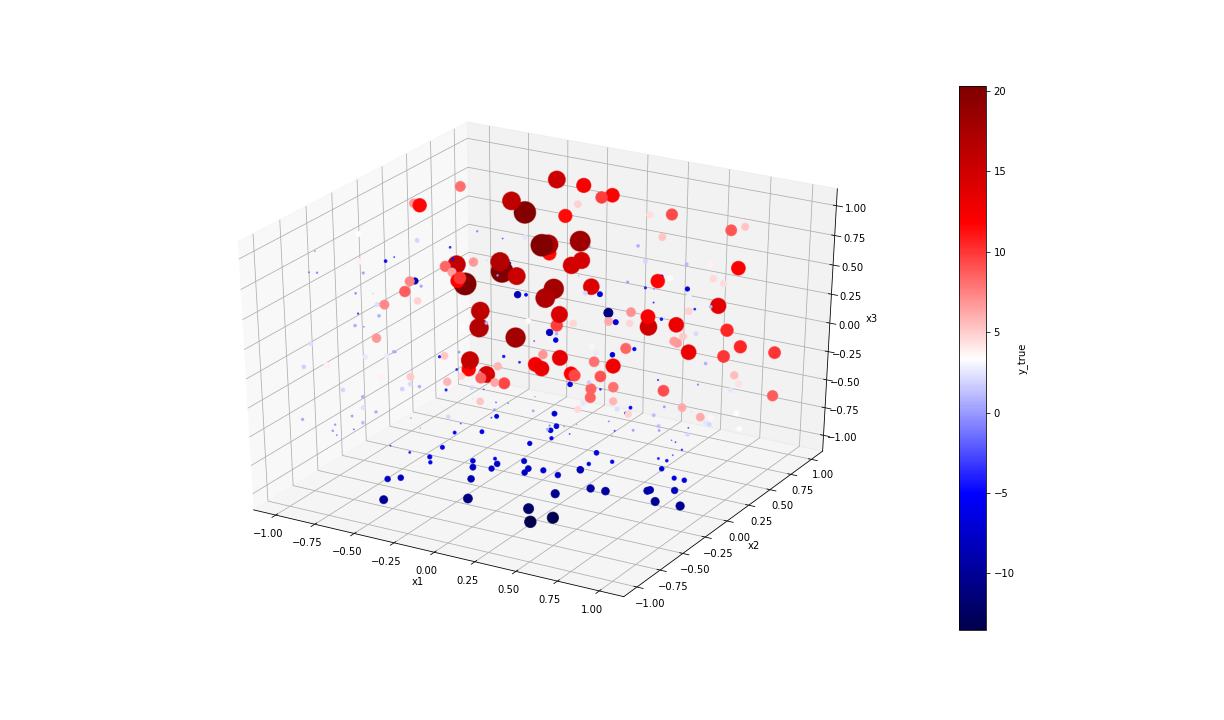

max : 20.284099794015997  min : -13.5285978007839


In [12]:
plot_4d(x[:,0], x[:,1], x[:,2], y1)

<IPython.core.display.Javascript object>


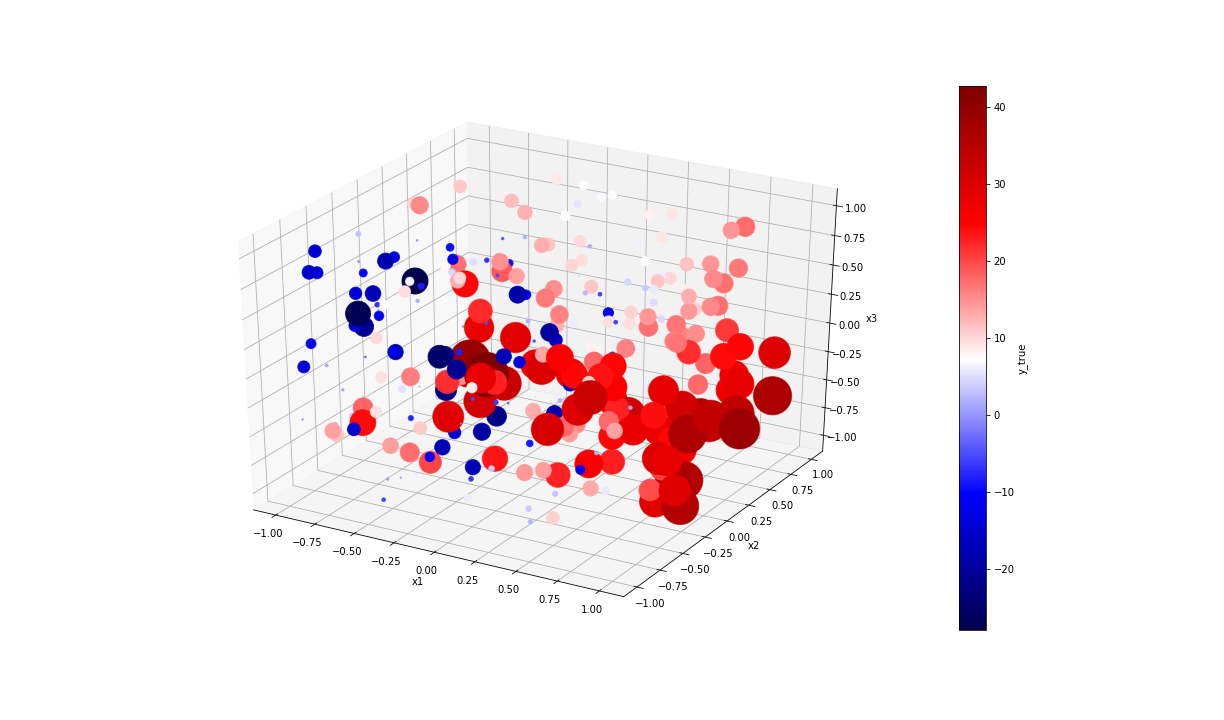

max : 42.6099130903702  min : -27.935697967500786


In [13]:
plot_4d(x[:,0], x[:,1], x[:,2], y2)

In [6]:
y_true = np.concatenate((y1,y2), axis=1)
print(x.shape)
print(y_true.shape)

(300, 3)
(300, 2)


In [7]:
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()

In [8]:
class Linear:
    
    def __init__(self, input_dim, num_neurons):
        self.weights = torch.randn(input_dim, num_neurons) * np.sqrt(2/ input_dim)
        self.bias = torch.zeros(1)
        self.weights.requires_grad_()
        self.bias.requires_grad_()
        
    def __call__(self, x):
        self.x = x
        output = x @ self.weights + self.bias
        return output
    
    
    def update(self, lr):
        # Updating weights and bias value calculated in backprop function
#         self.weights = self.weights - lr * self.w_gradient
#         self.bias = self.bias - lr * self.bias_gradient
        with torch.no_grad():
            self.weights -= lr * self.weights.grad
            self.bias -= lr * self.bias.grad
        self.weights.grad.zero_()
        self.bias.grad.zero_()
        
class Relu:
    def __call__(self, input):
        self.input = input
        self.output = torch.clip(self.input, 0, None)
        return self.output
    
class MSE:
    def __call__(self, y_true, y_pred):
        self.y_pred = y_pred
        self.y_true = y_true
        # MSE = (delta_y1^2/n + delta_y2^2/n + ...delta_yn^2/n)
        return ((self.y_pred - self.y_true)**2).mean()


class Model:
    def __init__(self, input_dim):
        self.linear_ip = Linear(input_dim, 5)
        self.relu1   = Relu()
        self.linear2 = Linear(5, 4)
        self.relu2   = Relu()
        self.linear_op = Linear(4, 2)
        
    def __call__(self,x):
        l1 = self.linear_ip(x)
#         print(f'l1 shape : {l1.shape}')
        r1 = self.relu1(l1)
#         print(f'r1 shape : {r1.shape}')
        l2 = self.linear2(r1)
#         print(f'l2 shape : {l2.shape}')
        r2 = self.relu2(l2)
        l3 = self.linear_op(r2)
        return l3
    
    
    def update(self, lr):
        self.linear_op.update(lr)
        self.linear2.update(lr)
        self.linear_ip.update(lr)
        


In [9]:
def fit(x, y_true, model, loss, lr=0.01, num_epoch=1000):
    
    for epoch in range(num_epoch):
        y_pred = model(x)
        loss_val = loss(y_true, y_pred)
        print(f'Epoch {epoch}, loss {loss_val}')
        loss_val.backward()
        model.update(lr)

In [10]:
loss = MSE()
model = Model(x_tensor.shape[1])
fit(x_tensor, y_true_tensor, model, loss)

Epoch 0, loss 176.74551391601562
Epoch 1, loss 174.39697265625
Epoch 2, loss 171.88427734375
Epoch 3, loss 169.14064025878906
Epoch 4, loss 166.05508422851562
Epoch 5, loss 162.50489807128906
Epoch 6, loss 158.32723999023438
Epoch 7, loss 153.41871643066406
Epoch 8, loss 147.66482543945312
Epoch 9, loss 141.00714111328125
Epoch 10, loss 133.63099670410156
Epoch 11, loss 125.77960968017578
Epoch 12, loss 117.7621078491211
Epoch 13, loss 109.67515563964844
Epoch 14, loss 101.62435913085938
Epoch 15, loss 93.99102020263672
Epoch 16, loss 87.0823974609375
Epoch 17, loss 80.96029663085938
Epoch 18, loss 75.5520248413086
Epoch 19, loss 71.00601959228516
Epoch 20, loss 67.41764831542969
Epoch 21, loss 64.66776275634766
Epoch 22, loss 62.5909423828125
Epoch 23, loss 61.00175094604492
Epoch 24, loss 59.728118896484375
Epoch 25, loss 58.70135498046875
Epoch 26, loss 57.82316589355469
Epoch 27, loss 57.108150482177734
Epoch 28, loss 56.48356246948242
Epoch 29, loss 55.907928466796875
Epoch 30, lo

Epoch 244, loss 2.7828588485717773
Epoch 245, loss 2.7628979682922363
Epoch 246, loss 2.7437431812286377
Epoch 247, loss 2.724587917327881
Epoch 248, loss 2.7057530879974365
Epoch 249, loss 2.6892497539520264
Epoch 250, loss 2.6733486652374268
Epoch 251, loss 2.6598188877105713
Epoch 252, loss 2.6454248428344727
Epoch 253, loss 2.635542869567871
Epoch 254, loss 2.6249821186065674
Epoch 255, loss 2.6205132007598877
Epoch 256, loss 2.615314245223999
Epoch 257, loss 2.615421772003174
Epoch 258, loss 2.615568161010742
Epoch 259, loss 2.6302266120910645
Epoch 260, loss 2.6403956413269043
Epoch 261, loss 2.673758029937744
Epoch 262, loss 2.6958377361297607
Epoch 263, loss 2.7615225315093994
Epoch 264, loss 2.8033413887023926
Epoch 265, loss 2.9235270023345947
Epoch 266, loss 2.9825141429901123
Epoch 267, loss 3.192988634109497
Epoch 268, loss 3.245994806289673
Epoch 269, loss 3.5901811122894287
Epoch 270, loss 3.6006767749786377
Epoch 271, loss 4.121872901916504
Epoch 272, loss 3.95231556892

Epoch 574, loss 1.657981514930725
Epoch 575, loss 1.6559903621673584
Epoch 576, loss 1.650935411453247
Epoch 577, loss 1.651507019996643
Epoch 578, loss 1.6473863124847412
Epoch 579, loss 1.645600438117981
Epoch 580, loss 1.641901969909668
Epoch 581, loss 1.6421666145324707
Epoch 582, loss 1.639043927192688
Epoch 583, loss 1.6391721963882446
Epoch 584, loss 1.6364386081695557
Epoch 585, loss 1.6372545957565308
Epoch 586, loss 1.634845495223999
Epoch 587, loss 1.6358038187026978
Epoch 588, loss 1.6335612535476685
Epoch 589, loss 1.6375160217285156
Epoch 590, loss 1.6355053186416626
Epoch 591, loss 1.6401883363723755
Epoch 592, loss 1.6362742185592651
Epoch 593, loss 1.6413609981536865
Epoch 594, loss 1.6376190185546875
Epoch 595, loss 1.644386649131775
Epoch 596, loss 1.641971468925476
Epoch 597, loss 1.649938702583313
Epoch 598, loss 1.6476507186889648
Epoch 599, loss 1.6570888757705688
Epoch 600, loss 1.6547441482543945
Epoch 601, loss 1.6659009456634521
Epoch 602, loss 1.661277055740

Epoch 881, loss 1.6266196966171265
Epoch 882, loss 1.6111193895339966
Epoch 883, loss 1.6434109210968018
Epoch 884, loss 1.6267313957214355
Epoch 885, loss 1.664365291595459
Epoch 886, loss 1.6463758945465088
Epoch 887, loss 1.6884478330612183
Epoch 888, loss 1.668250322341919
Epoch 889, loss 1.7149658203125
Epoch 890, loss 1.6845818758010864
Epoch 891, loss 1.7341645956039429
Epoch 892, loss 1.6990045309066772
Epoch 893, loss 1.7509684562683105
Epoch 894, loss 1.71239173412323
Epoch 895, loss 1.7653523683547974
Epoch 896, loss 1.7254984378814697
Epoch 897, loss 1.780684232711792
Epoch 898, loss 1.7393202781677246
Epoch 899, loss 1.79698646068573
Epoch 900, loss 1.753848910331726
Epoch 901, loss 1.8142179250717163
Epoch 902, loss 1.764600396156311
Epoch 903, loss 1.8293169736862183
Epoch 904, loss 1.778102159500122
Epoch 905, loss 1.8451056480407715
Epoch 906, loss 1.7919573783874512
Epoch 907, loss 1.8613125085830688
Epoch 908, loss 1.7990895509719849
Epoch 909, loss 1.868733525276184

In [14]:
y_pred_tensor = model(x_tensor)
y_pred = y_pred_tensor.detach().numpy()
y1_pred = y_pred[:,0].reshape(300,1)
y2_pred = y_pred[:,1].reshape(300,1)

<IPython.core.display.Javascript object>


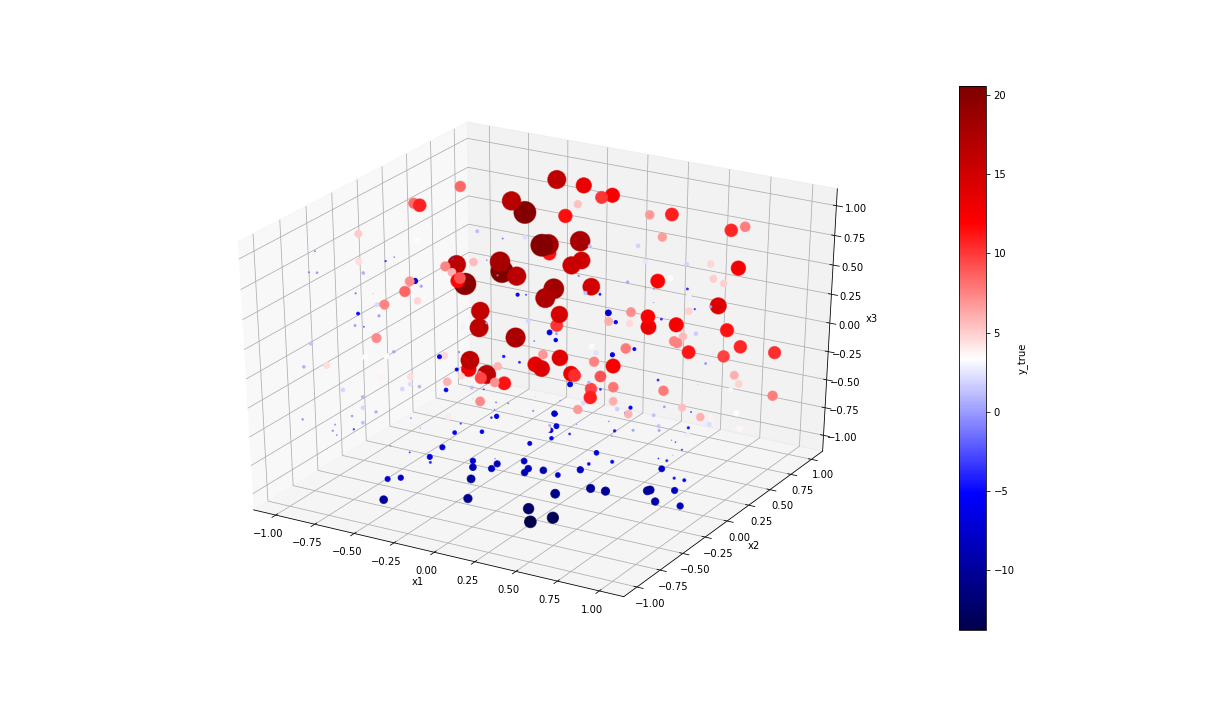

max : 20.542802810668945  min : -13.764883041381836


In [15]:
plot_4d(x[:,0], x[:,1], x[:,2], y1_pred)

<IPython.core.display.Javascript object>


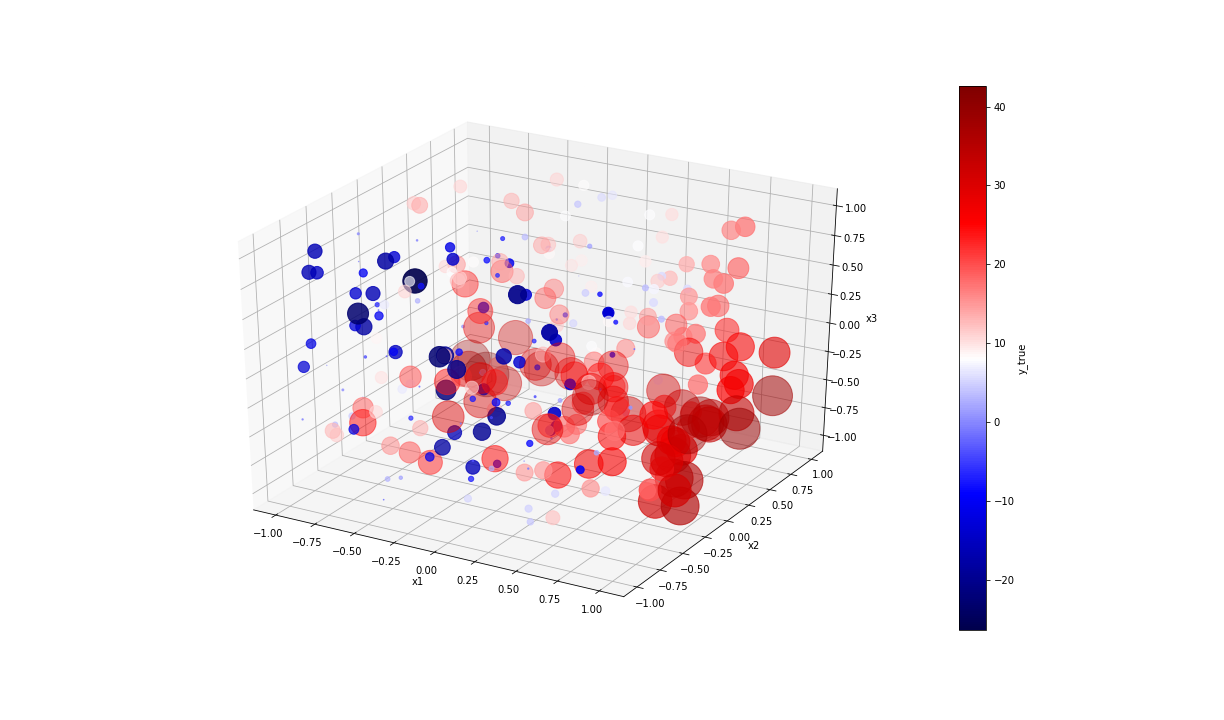

max : 42.55126190185547  min : -26.31296730041504


In [16]:
plot_4d(x[:,0], x[:,1], x[:,2], y2_pred)